In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [20]:
import pandas as pd

# Load train and test data
train_data = pd.read_csv("D:/News Category Classifier/train.csv")
test_data = pd.read_csv("D:/News Category Classifier/test.csv")

# See the first few rows of the data.
print("Train Data:")
print(train_data.head())

print("\nTest Data:")
print(test_data.head())

Train Data:
   Class Index                                              Title  \
0            3  Wall St. Bears Claw Back Into the Black (Reuters)   
1            3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2            3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3            3  Iraq Halts Oil Exports from Main Southern Pipe...   
4            3  Oil prices soar to all-time record, posing new...   

                                         Description  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil prices, toppling reco...  

Test Data:
   Class Index                                              Title  \
0            3                  Fears for T N pension after talks   
1            4  The Race is On: Second Private Team Sets Launc...   
2            4      Ky. 

In [21]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK (when run for the first time)
'''import nltk
nltk.download('stopwords')
nltk.download('wordnet')'''

# Text Cleaning Function
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    
    # Lowercase it
    text = text.lower()
    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove stop words and perform lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stopwords.words('english')]
    return ' '.join(words)

# Apply preprocessing to the train and test data.
for df in [train_data, test_data]:
    df['Processed_Title'] = df['Title'].apply(preprocess_text)
    df['Processed_Description'] = df['Description'].apply(preprocess_text)
    df['Combined_Text'] = df['Processed_Title'] + ' ' + df['Processed_Description']

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Just fit into the train data.
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['Combined_Text'])

# Transform it into test data
X_test_tfidf = tfidf_vectorizer.transform(test_data['Combined_Text'])

# Target variable
y_train = train_data['Class Index']
y_test = test_data['Class Index']

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Initialize the model
model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
model.fit(X_train_tfidf, y_train)

# Make a prediction
y_pred = model.predict(X_test_tfidf)

# Print the report
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.2f}")

Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.90      0.91      1900
           2       0.95      0.97      0.96      1900
           3       0.88      0.87      0.87      1900
           4       0.88      0.88      0.88      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600


Accuracy: 0.91


In [24]:
print("Train Class Distribution:")
print(train_data['Class Index'].value_counts())

print("\nTest Class Distribution:")
print(test_data['Class Index'].value_counts())

Train Class Distribution:
Class Index
3    30000
4    30000
2    30000
1    30000
Name: count, dtype: int64

Test Class Distribution:
Class Index
3    1900
4    1900
2    1900
1    1900
Name: count, dtype: int64


In [25]:
import joblib

# Save model and vectorizer
joblib.dump(model, 'news_classifier_model.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

# While loading
loaded_model = joblib.load('news_classifier_model.pkl')
loaded_vectorizer = joblib.load('tfidf_vectorizer.pkl')

In [26]:
def predict_news_category(news_title, news_description):
    # Preprocessing
    processed_title = preprocess_text(news_title)
    processed_desc = preprocess_text(news_description)
    combined_text = processed_title + " " + processed_desc
    
    # Vectorization
    text_vector = loaded_vectorizer.transform([combined_text])
    
    # Prediction
    prediction = loaded_model.predict(text_vector)
    return prediction[0]

# Test it
sample_title = "Wall St. Bears Claw Back Into the Black"
sample_desc = "Reuters - Short-sellers, Wall Street's dwindling..."
print("Predicted Category:", predict_news_category(sample_title, sample_desc))

Predicted Category: 3


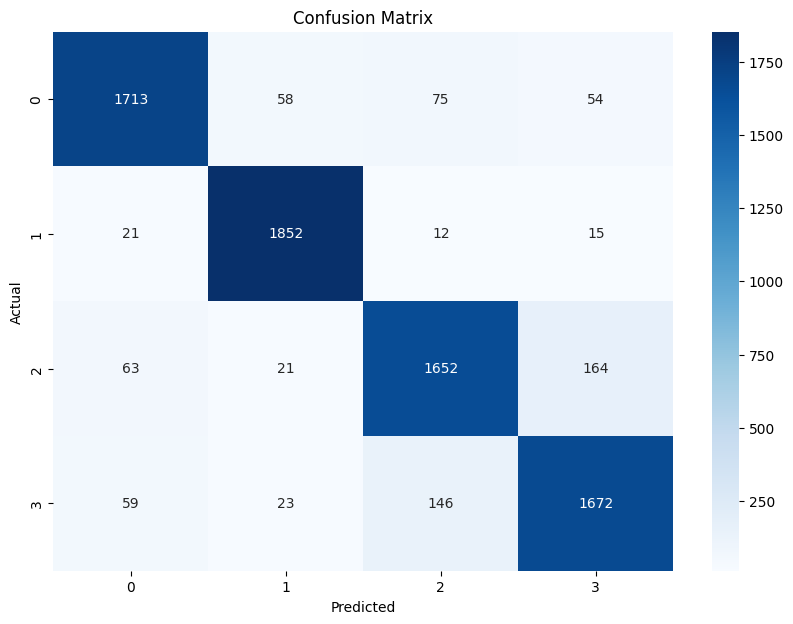

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()